# Skipper Noise Modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import astropy.units as u
import astropy.constants as c
from astropy.visualization import quantity_support
import pandas as pd
from scipy.integrate import simpson

In [2]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

In [58]:
@u.quantity_input(f=u.Hz, t=u.s)
def transfer(f,t):
    '''
    t is the integration time of the signal and pedestal levels
    f is the frequency at which the ccd is clocked
    '''
    t = t / 2 # 
    # f = f*2*np.pi

    noise_density = 2 * (np.sin((np.pi * f * t).to(u.rad, equivalencies=u.dimensionless_angles())))**2 / ((np.pi * f * t).to(u.rad, equivalencies=u.dimensionless_angles()))
    return noise_density

@u.quantity_input(f1=u.Hz, f2=u.Hz, t=u.s)
def sig_cds(ewn, t, f1, f2):
    '''
    ewn is voltage noise density of white noise
    '''
    t = t / 2 
    # f1 = f1*2*np.pi
    # f2 = f2*2*np.pi

    return ewn * np.sqrt(1/t + 4*f1.si*np.log(2) + 4/3 * f2**2 * np.pi**2 * t)

@u.quantity_input(f1=u.Hz, f2=u.Hz, t=u.s)
def sig_skipper(n, ewn, t, f1, f2):
    '''
    ewn is voltage noise density of white noise
    '''
    t = t / 2 
    # f1 = f1*2*np.pi
    # f2 = f2*2*np.pi

    return ewn * np.sqrt(1/t + 4*f1*np.log(2) + 4/3 * f2**2 * np.pi**2 * t) / np.sqrt(n)

@u.quantity_input(speed=u.s, noise_freqs=u.Hz)
def total_noise(speed, noise_density, noise_freqs):
    '''Calculate total noise by convolving the noise density spectrum with the CDS transfer function.'''

    try:
        length = len(speed)
        variance = []
        for i in range(length):
            value = simpson((noise_density * transfer(noise_freqs, speed[i]))**2, noise_freqs)
            variance.append(value)

    except:
        variance = simpson((noise_density * transfer(noise_freqs, speed))**2, noise_freqs)
        
    sigma = np.sqrt(variance)
    return sigma

## Plot CDS Transfer Functions

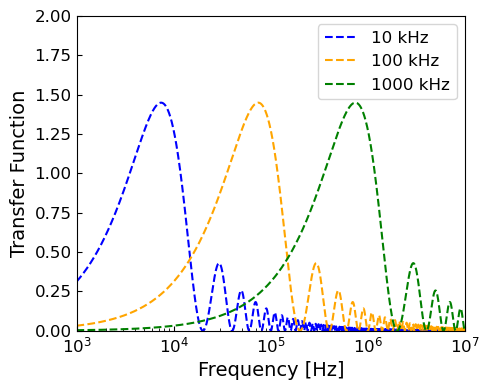

In [5]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')


freqs = np.logspace(0,10,10000) * u.Hz
tau = np.logspace(-9, -3, 10000) * u.s 

int_speed_10 = 1/(10*u.kHz)
int_speed_100 = 1/(100*u.kHz)
int_speed_1000 = 1/(1*u.MHz)

ax.plot(freqs, transfer(freqs, int_speed_10), label = '{:.0f}'.format((1/int_speed_10).to(u.kHz)), color = 'blue', ls='--')
ax.plot(freqs, transfer(freqs, int_speed_100), label = '{:.0f}'.format((1/int_speed_100).to(u.kHz)), color = 'orange', ls='--')
ax.plot(freqs, transfer(freqs, int_speed_1000), label = '{:.0f}'.format((1/int_speed_1000).to(u.kHz)), color='green', ls='--')

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Transfer Function')
ax.legend(loc = 'best')
ax.set_xlim(1e3, 1e7)
ax.set_xscale('log')
ax.set_ylim(0, 2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

# plt.savefig('C:/Users/Brock/Documents/Git/Research/CCDs/cds_transfer_func.png', dpi=250)
# plt.savefig('/home/baparker/GitHub/Research/CCDs/cds_transfer_func.png', dpi=250)
plt.show()

## Plot Skipper Transfer Function

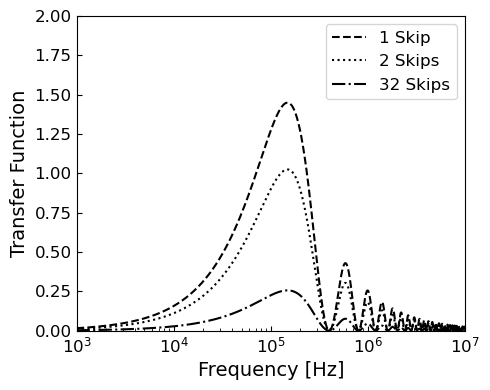

In [117]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')

freqs = np.logspace(0,10,10000) * u.Hz
tau = np.logspace(-9, -3, 10000) * u.s 

int_speed = 1/(2e5*u.Hz)
nskip1 = 2
nskip2 = 32

ax.plot(freqs, transfer(freqs, int_speed), color = 'black', ls='--', label='1 Skip')
ax.plot(freqs, transfer(freqs, int_speed) / np.sqrt(nskip1), color = 'black', ls=':', label='2 Skips')
ax.plot(freqs, transfer(freqs, int_speed) / np.sqrt(nskip2), color = 'black', ls='dashdot', label='32 Skips')

ax.set_xlabel(r'Frequency [Hz]')
ax.set_ylabel(r'Transfer Function')
ax.legend(loc = 'best')
ax.set_xlim(1e3, 1e7)
ax.set_xscale('log')
ax.set_ylim(0, 2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

# plt.savefig('C:/Users/Brock/Documents/Git/Research/CCDs/cds_transfer_func.png', dpi=250)
# plt.savefig('/home/baparker/GitHub/Research/CCDs/cds_transfer_func.png', dpi=250)
plt.show()

## Plot Total Integrated Noise vs Read Time and Skips

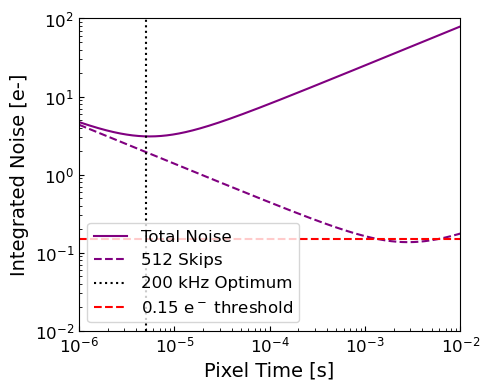

In [103]:
quantity_support()

fig, ax = plt.subplots(1, 1, figsize=(5,4), layout='tight')

freqs = np.logspace(0,10,10000) * u.Hz
tau = np.logspace(-9, -2, 10000) * u.s 

wn_floor = 2e-8 * u.V / ((u.Hz)**(1/2))
nc_1f = 100 * u.kHz
nc_1f2 = 100 * u.kHz

skips = 512

conversion = 6.5e-6
# Steve recommended 5e-6

ax.plot(tau, sig_cds(wn_floor, tau, nc_1f, nc_1f2) / conversion, label='Total Noise', color='purple')
ax.plot(tau * skips, sig_skipper(skips, wn_floor, tau, nc_1f, nc_1f2) / conversion, label='512 Skips', color='purple', ls='--')
ax.axvline(1/(200 * u.kHz), label='200 kHz Optimum', color='k', ls=':')
ax.axhline(0.15, color='red', ls='--', label='0.15 e$^-$ threshold')

ax.set_xlabel(r'Pixel Time [s]')
ax.set_ylabel(r'Integrated Noise [e-]')
ax.legend(loc = 'best')
ax.set_xlim(1e-6, 1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

# plt.savefig('C:/Users/Brock/Documents/Git/Research/CCDs/ccd_integrated_noise.png', dpi=250)
# plt.savefig('/home/baparker/GitHub/Research/CCDs/ccd_integrated_noise.png', dpi=250)
plt.show()

## Plot Measured STA Noise Spectrum

In [120]:
# noise_spectrum = pd.read_csv(r'C:/Users/Brock/Documents/Git/Research/CCDs/STANoiseSpectrum.csv', header=None)
noise_spectrum = pd.read_csv(r'F:/Github/Research/CCDs/STANoiseSpectrum.csv', header=None)
noise_freqs = np.array(noise_spectrum[0]) * u.Hz
noise_density = np.array(noise_spectrum[1]) * u.V / u.Hz**1/2
noise_density = noise_density*2 # scale factor from extraction

opt_speed = 1/(200*u.kHz)
cds_transfer = transfer(noise_freqs, opt_speed)

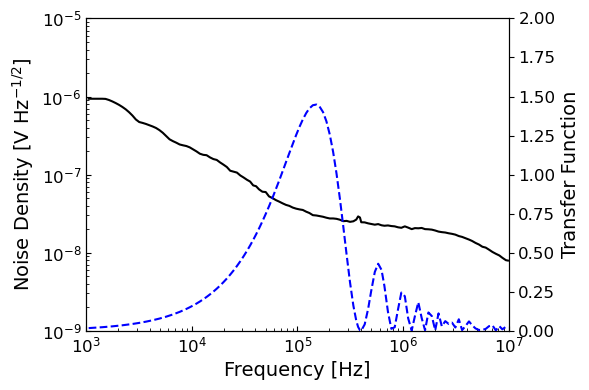

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='tight')
ax2 = ax.twinx()

ax2.plot(noise_freqs, cds_transfer, color = 'blue', ls='--')
ax.plot(noise_freqs, noise_density, color='black', ls='-')

ax.set_xlabel(r'Frequency [Hz]')
ax2.set_ylabel(r'Transfer Function')
ax.set_ylabel(r'Noise Density [V Hz$^{-1/2}$]')
# ax.legend(loc = 'best')
ax.set_xlim(1e3, 1e7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-5)
ax2.set_ylim(0, 2)

ax.tick_params(axis='both', direction='in', which='both')

fig.tight_layout()

# plt.savefig('C:/Users/Brock/Documents/Git/Research/CCDs/noise_spectrum_data.png', dpi=250)
# plt.savefig('/home/baparker/GitHub/Research/CCDs/ccd_integrated_noise.png', dpi=250)
plt.show()

## Plot Total Noise as a Function of Frequency

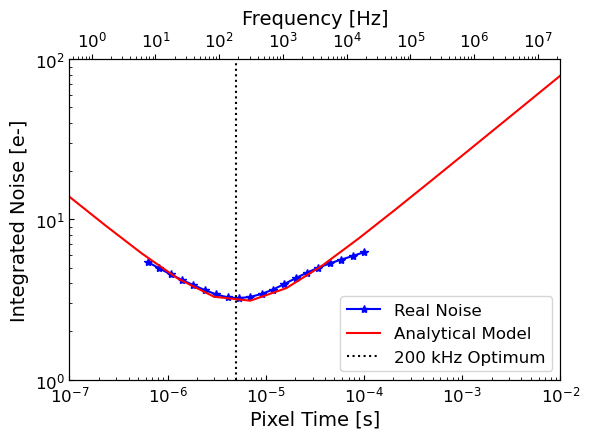

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')
ax3 = ax.twiny()

array_len = 20

taus = 1 / (np.logspace(0, 7, array_len) * u.Hz)
plot_taus = 1 / (np.logspace(4, 6.2, array_len) * u.Hz)

# Calculate conversion factor to normalize STA spectrum to 3.5 e- at 100kHz
# noise_100 = total_noise(1/(100*u.kHz), noise_density, noise_freqs)
# factor = 3.5 / noise_100 * conversion
# Not needed with proper noise spectrum

output_noise = total_noise(plot_taus, noise_density, noise_freqs)
ax.plot(plot_taus, output_noise / conversion * factor, color='blue', ls='-', label='Real Noise', marker='*')
ax.plot(taus, sig_cds(wn_floor, taus, nc_1f, nc_1f2) / conversion, color='red', label='Analytical Model')

ax3.plot(1/taus, [0]*array_len, color='green', ls='-')

ax.axvline(1/(200 * u.kHz), label='200 kHz Optimum', color='k', ls=':')
# ax.axhline(0.15, color='red', ls='--', label='0.15 e$^-$ threshold')

ax.set_xlabel(r'Pixel Time [s]')
ax.set_ylabel(r'Integrated Noise [e-]')
ax3.set_xlabel(r'Frequency [Hz]')
ax.legend(loc = 'best')
ax.set_xlim(1e-7, 1e-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax3.set_xscale('log')
ax.set_ylim(1e0, 1e2)

ax.tick_params(axis='both', direction='in', which='both')
 
fig.tight_layout()

# plt.savefig('C:/Users/Brock/Documents/Git/Research/CCDs/ccd_integrated_noise_data.png', dpi=250)
# plt.savefig('/home/baparker/GitHub/Research/CCDs/ccd_integrated_noise.png', dpi=250)
plt.show()

## Model Noise Spectrum

In [123]:
factor

0.9953635916264005